# Quiz 5
Authors: Daniel Carneiro Freire **2016074250**, Felipe Bartelt de Assis Pessoa **2016026841**

In this quiz we were tasked with implementing four classifiers for the CIFAR10 image dataset.
1. Using bag of features to train a random forest classifier
2. Using bag of features to train a neural network
3. Using the dataset to train a convolutional neural network
4. Using the convolutional layer of the previous classifier to train a random forest classifier

We will be implementing the first two in this notebook, and comparing their results.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             plot_confusion_matrix)
from tensorflow.keras.models import Sequential


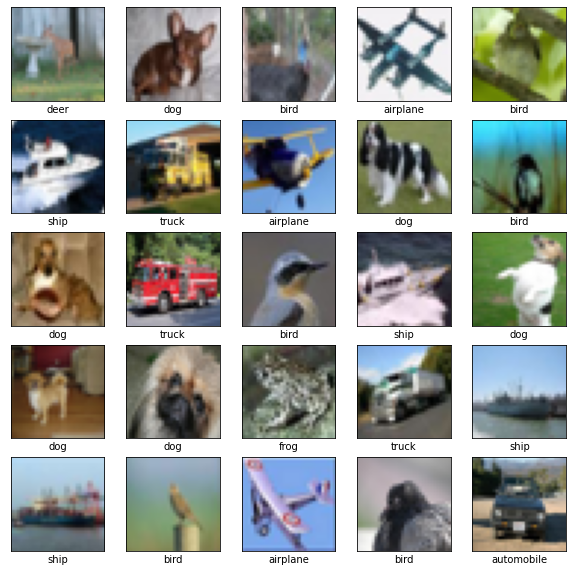

In [5]:
# Load the data and convert to grayscale
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
rng = np.random.default_rng()
idxs = rng.integers(0, x_train.shape[0], size = 25)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idxs[i]])
    plt.xlabel(class_names[y_train[idxs[i]][0]])
plt.show()

x_train = tf.image.rgb_to_grayscale(x_train)
x_test = tf.image.rgb_to_grayscale(x_test)

In [6]:
# Get the keypoints and descriptors for the training and test images. We chose the Fast feature detector, since it produced the best results
det = cv2.FastFeatureDetector_create()
com = cv2.SIFT_create()


def features(image, detector, extractor):
    keypoints = detector.detect(image, None)
    keypoints, descriptors = extractor.compute(image, keypoints)
    return keypoints, descriptors


desc_list = []
train_descriptors = []
for img, label in zip(x_train, y_train):
    keypoints, descriptors = features(img.numpy(), det, com)
    if descriptors is not None:
        train_descriptors.append((descriptors, label))
        desc_list.extend(descriptors)

test_descriptors = []
test_labels = []
for img, label in zip(x_test, y_test):
    keypoints, descriptors = features(img.numpy(), det, com)
    if descriptors is not None:
        test_descriptors.append((descriptors, label))

len(desc_list)

1855453

In [7]:
# Cluster descriptor using MiniMatchKMeans (Much faster than KMeans, and required if we want to have this many clusters without consuming too much memory)
%%capture

kmeans = MiniBatchKMeans(n_clusters=1000);
kmeans.fit(desc_list)
visual_words = kmeans.cluster_centers_

In [8]:

def get_hist(descriptors, kmeans):
    """Get the bag of features histogram for the given descriptors and kmeans model
    """    
    hist = np.zeros(len(kmeans.cluster_centers_), dtype=np.uint8)
    descriptors = np.array(descriptors, dtype=np.float)
    if descriptors is not None:
        pred = kmeans.predict(descriptors)
        unique, counts = np.unique(pred, return_counts=True)
        hist[unique-1] = counts
    return hist
        

In [10]:
%%capture

# Get the bag of features for each training and test image

train_hist = []
for descriptor, label in train_descriptors:
    train_hist.append((get_hist(descriptor, kmeans), label));
    
test_hist = []
for descriptor, label in test_descriptors:
    test_hist.append((get_hist(descriptor, kmeans), label));

In [11]:
x_hist_train = np.array([hist for hist, _ in train_hist])
y_hist_train = np.array([label for _, label in train_hist])
x_hist_test = np.array([hist for hist, _ in test_hist])
y_hist_test = np.array([label for _, label in test_hist])

In [12]:
# Train the random forest classifier

test_desc_list = []
for td in test_descriptors:
    test_desc_list.extend(td)

clf = RandomForestClassifier(max_depth=10, random_state=0);
clf.fit(x_hist_train, y_hist_train);

/tmp/ipykernel_975046/1846952040.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_hist_train, y_hist_train);


Bellow we measure the precision of the random forest classifier. We can see that although it does better than guessing, its precision is still too low to be considered realiable at all. The random forest has a particularly hard time at classifying cats, in the test set it almost never predicts that an image is a cat, and usually predicts other furry animals instead.

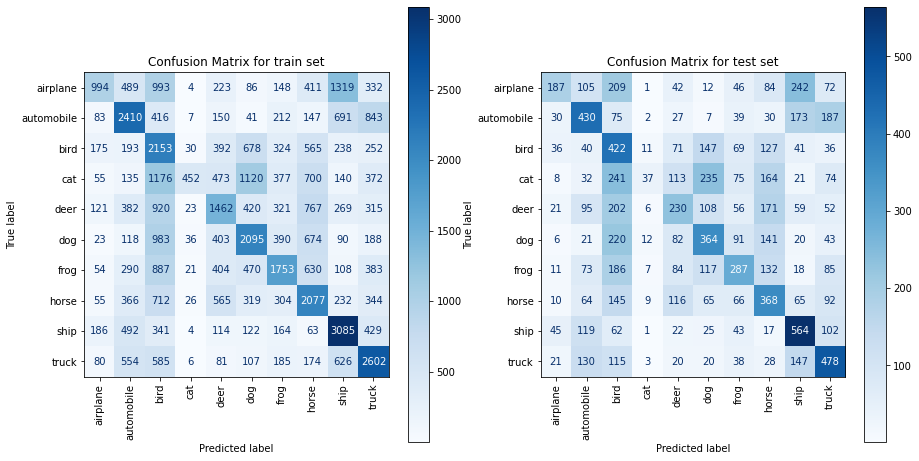

Accuracy of the classifier on the train set: 0.38166763335266707
Accuracy of the classifier on the test set: 0.3367


In [15]:


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig1, ax1 = plt.subplots(1,2)
plot_confusion_matrix(clf, x_hist_train, y_hist_train.ravel(), ax=ax1[0], xticks_rotation = 'vertical', 
                      display_labels=class_names, values_format = '.5g', cmap=plt.cm.Blues)
plot_confusion_matrix(clf, x_hist_test, y_hist_test.ravel(), ax=ax1[1], xticks_rotation = 'vertical',
                      display_labels=class_names, values_format = '.5g', cmap=plt.cm.Blues)

ax1[0].set_title('Confusion Matrix for train set')
ax1[1].set_title('Confusion Matrix for test set')
fig1.set_size_inches(15, 8)
plt.show()

tree_score_train = clf.score(x_hist_train, y_hist_train)
tree_score_test = clf.score(x_hist_test, y_hist_test)

print(f'Accuracy of the classifier on the train set: {tree_score_train}')
print(f'Accuracy of the classifier on the test set: {tree_score_test}')


In [16]:
# Head of LeNet5

model = Sequential()

model.add(Dense(84, activation='tanh', input_shape=(len(kmeans.cluster_centers_),)))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 84)                84084     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                850       
Total params: 84,934
Trainable params: 84,934
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train the model

model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(x_hist_train, y_hist_train, epochs=5, validation_data=(x_hist_test, y_hist_test))

2021-08-15 22:34:02.020406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7073 - accuracy: 0.3945 - val_loss: 1.6418 - val_accuracy: 0.4156
Epoch 2/5
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5708 - accuracy: 0.4428 - val_loss: 1.6179 - val_accuracy: 0.4274
Epoch 3/5
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5208 - accuracy: 0.4580 - val_loss: 1.6141 - val_accuracy: 0.4297
Epoch 4/5
1563/1563 [==============================] - 3s 2ms/step - loss: 1.4793 - accuracy: 0.4697 - val_loss: 1.6125 - val_accuracy: 0.4330
Epoch 5/5
1563/1563 [==============================] - 3s 2ms/step - loss: 1.4357 - accuracy: 0.4874 - val_loss: 1.6210 - val_accuracy: 0.4319


Here we measure the precision of the neural network. As we can see it did considerably better than the random forest classifier, but not by much. With these kind of results it seems that maybe training a neural network with only the descriptors of an image, without doing a more sofisticated preprocessing step, does not peform well. (Also it does a bad job at predicting cats)

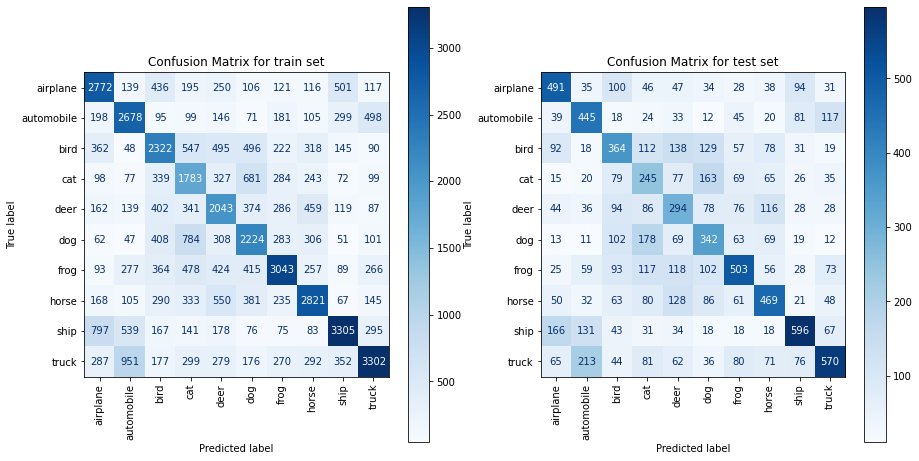

In [18]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
fig1, ax1 = plt.subplots(1,2)

train_pred = model.predict(x_hist_train)
train_pred = np.argmax(train_pred, axis=1) 
c1 = confusion_matrix(train_pred, y_hist_train.ravel())

test_pred = model.predict(x_hist_test)
test_pred = np.argmax(test_pred, axis=1) 
c2 = confusion_matrix(test_pred, y_hist_test.ravel())

disp = ConfusionMatrixDisplay(confusion_matrix=c1, display_labels=class_names)
disp.plot(include_values=True,
                     cmap=plt.cm.Blues, ax=ax1[0], xticks_rotation='vertical',
                     values_format=".5g", colorbar=True)


disp = ConfusionMatrixDisplay(confusion_matrix=c2, display_labels=class_names)
disp.plot(include_values=True,
                     cmap=plt.cm.Blues, ax=ax1[1], xticks_rotation='vertical',
                     values_format=".5g", colorbar=True)

ax1[0].set_title('Confusion Matrix for train set')
ax1[1].set_title('Confusion Matrix for test set')
fig1.set_size_inches(15, 8)

clf.score([hist for hist, _ in test_hist], [label for _, label in test_hist])

plt.show()

In [19]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_hist_train, train_pred)
r1 = m.result().numpy()

m = tf.keras.metrics.Accuracy()
m.update_state(y_hist_test, test_pred)
r2 = m.result().numpy()

print(f'Mean train accuracy: {r1}')
print(f'Mean test accuracy: {r2}')

Mean train accuracy: 0.5258705019950867
Mean test accuracy: 0.4318999946117401
